In [46]:
import numpy as np
from astropy.io import fits
import datetime 
import matplotlib.pyplot as plt
# from matplotlib import cm
##from validation import *
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
#from skimage.transform import resize
import os
import sys
sys.path.append('../radiospectra2')

# import radiospectra2
from radiospectra.sources import CallistoSpectrogram

from matplotlib.ticker import MaxNLocator, IndexLocator
from scipy import interpolate
from copy import deepcopy
import matplotlib.ticker as ticker
from matplotlib.dates import MinuteLocator
# #import julian

In [156]:
# final Version

class OrfeesSpectrogram(CallistoSpectrogram):
    
    def __init__(self, file=None,  t_label="Time",  f_label="Frequency"):
        data = {}
        
        if file:
            data = self.read_orfees(file)
               
        self.__init_values__(**data)
            
    def __init_values__(self, **kwargs):
        self.data = kwargs.get("data", None)
        self.time_axis = kwargs.get("time_axis", None)
        self.freq_axis = kwargs.get("freq_axis", None)
        self.date_obs = kwargs.get("date_obs", None)
        self.time_start_obs = kwargs.get("time_start_obs", None)
        self.time_end_obs = kwargs.get("time_end_obs", None)

        self.t_label = kwargs.get("t_label", None)
        self.f_label = kwargs.get("f_label", None)
  

    def read_orfees(self, filename):
        hdulist=fits.open(filename)

        h_file = hdulist[0].header
        frequency = hdulist[1].data
        h_data = hdulist[2].data 


        date_obs = h_file[4]
        time_start_obs = h_file[5]
        time_end_obs = h_file[7]
        # time_integration=h_file[9]

        # STOKESI_B: nata for Stokes parameter I (STOKESI) per bann
        data_SI_B1 = h_data.STOKESI_B1
        data_SI_B2 = h_data.STOKESI_B2
        data_SI_B3 = h_data.STOKESI_B3
        data_SI_B4 = h_data.STOKESI_B4
        data_SI_B5 = h_data.STOKESI_B5

        # TIME_B: Time in seconn per bann
        time_1 = h_data.TIME_B1
        time_2 = h_data.TIME_B2
        time_3 = h_data.TIME_B3
        time_4 = h_data.TIME_B4
        time_5 = h_data.TIME_B5

        # The Frequency 
        freq_b1=frequency.FREQ_B1[0]
        freq_b2=frequency.FREQ_B2[0]
        freq_b3=frequency.FREQ_B3[0]
        freq_b4=frequency.FREQ_B4[0]
        freq_b5=frequency.FREQ_B5[0]
        
        # concatenate all together using np.concatenate
        time_axis = np.concatenate([time_1, time_2, time_3, time_4, time_5])
        freq_axis = np.concatenate([freq_b1,freq_b2,freq_b3,freq_b4,freq_b5])
        data = np.concatenate([data_SI_B1,data_SI_B2,data_SI_B3,data_SI_B4,data_SI_B5],axis=1)

        return {
            "data": data,
            "time_axis": time_axis,
            "freq_axis": freq_axis,
            "date_obs": date_obs,
            "time_start_obs": time_start_obs,
            "time_end_obs": time_end_obs
        }
    
    
    def convert_ms_to_date(self):
        # this function get the time axis from orfees file as miliseconds and convert it to date, return a list.(12:00:04.932000)

        times = self.time_axis
        
        list_of_times= []
        for time in times:
            delta = datetime.timedelta(0, 0, 0, int(time))
            list_of_times.append(str(delta).split(".")[0])

        return list_of_times
    

    def peek(self):

        fig, ax = plt.subplots()
        dates = self.convert_ms_to_date()

        # xa = ax.get_xaxis()
        # ya = ax.get_yaxis()

        # dist = (self.freq_axis[0] - self.freq_axis[-1]) / nticks
        # dist = max(round(dist, -1), 10)

        # ya.set_major_locator(
        #         IndexLocator(
        #             dist, offset=0
        #         )
        #     )

        ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
        ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")
    
        plt.imshow(self.data[:, 240:370].transpose(), vmin = self.data.min(), vmax = 1000, aspect="auto")
        plt.colorbar()
       
        plt.title(f"ORFEES, {self.date_obs}")
        plt.xlabel('Time[UT]')
        plt.ylabel('Frequency [MHz]')

        plt.show()

(90, 998)


/tmp/ipykernel_318/1670031717.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


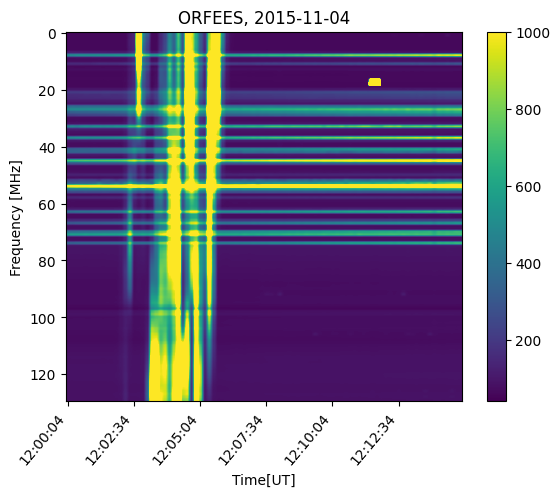

In [157]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
print(orfees.data.shape)
orfees.peek()

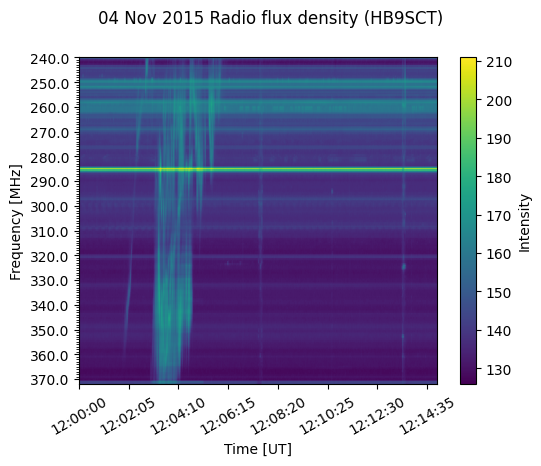

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [19]:
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
spec.peek()

In [11]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
print(orfees.data.shape)
print(spec.data.shape)

# steps
# make the spec.data.shape[1] to 90 
# make the the orfees.data.shape[1] to 200 

# print(data.shape[0])
# # height, width = data.shape
# # data = average(split(average(split(data, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)
# data.reshape((2,data.shape[0]//2,3,-1)).mean(3).mean(1)

(90, 998)
(200, 3600)


In [233]:
# def convert_ms_tO_date(file):
    
#     orf_file = OrfeesSpectrogram(file)
    
#     times= orf_file.time_axis
#     base_datetime = orf_file.date_obs
#     list_of_times= []
#     for date in times:
#         delta = str(datetime.timedelta(0, 0, 0, int(date)))
#         target_datetime = base_datetime +" " + delta
#         list_of_times.append(target_datetime[11:-7])

#     return list_of_times

# orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")

# fig, ax = plt.subplots()

# dates = convert_ms_tO_date("./orfees_files/int_orf20151104_120000_10.fts")

# ax.xaxis.set_major_locator(MaxNLocator(prune = "both", nbins = 6))

# ax.set_xticklabels(dates[::int(len(dates)//30)], rotation = 50, horizontalalignment="right")
# plt.imshow(orfees.data.transpose(), vmin = 100, vmax = 1000, aspect="auto")

# plt.colorbar()
# plt.show()

In [187]:
# spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
# spec.peek()
# # print(spec.header["TIME-OBS"])
# # spec.header["CDELT1"]
# def convert_ms_tO_date(spec):
    
    
#     time_delta = spec.time_axis
    
#     list_of_times= []
#     for time in time_delta:
#         delta = datetime.datetime.strptime(spec.header["TIME-OBS"],'%H:%M:%S.%f')  + datetime.timedelta(time)
#         list_of_times.append(delta)

#     return list_of_times

/tmp/ipykernel_396/1185922232.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


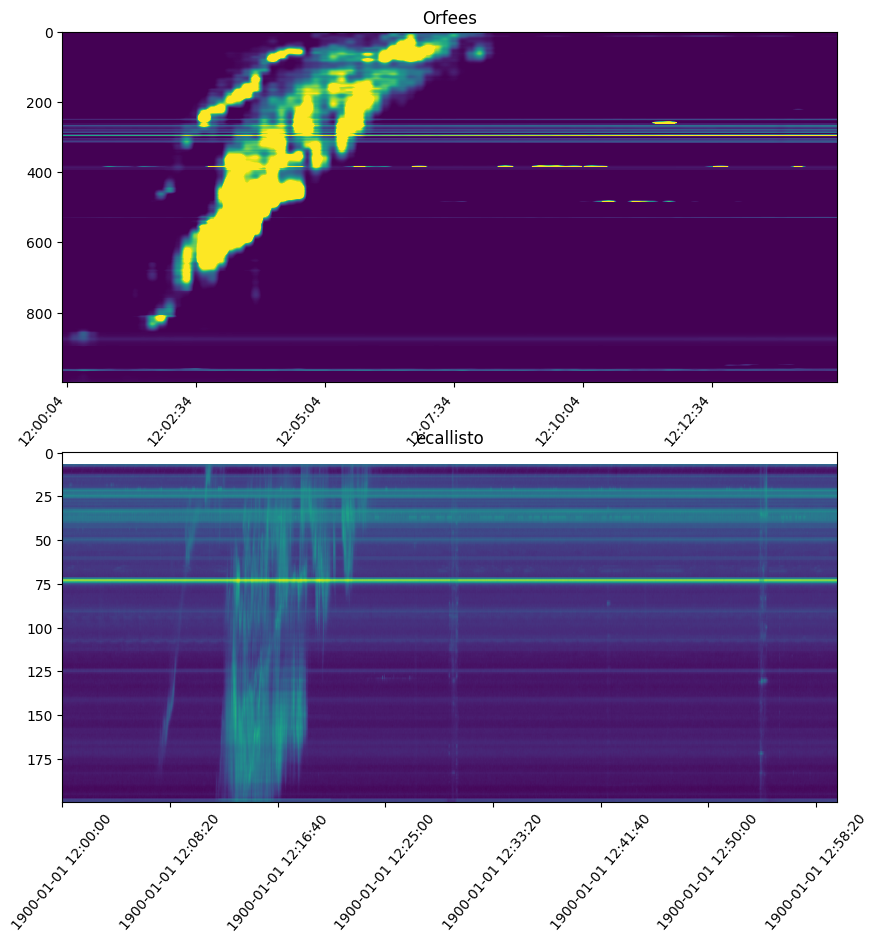

In [4]:
test_orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")

dates = test_orfees.convert_ms_to_date()

fig, axs = plt.subplots(nrows=2,  figsize=(10, 10))

axs[0].set_title('Orfees')

xa1 = axs[0].get_xaxis()

axs[0].xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=6))

axs[0].set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")
axs[0].tick_params(axis='x', labelrotation = 50)
axs[0].imshow(test_orfees.data.transpose(), vmin = 100, vmax = 1000, aspect="auto")

# # axs[0].set_xlim(0, 3600)
# # axs[0].set_ylim(200)

# fig.subplots_adjust(hspace=.5)

xa2 = axs[1].get_xaxis()
axs[1].tick_params(axis='x', labelrotation = 50)


axs[1].set_title('ecallisto')
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
# date_start2 = spec.header["DATE-OBS"] + " " + spec.header["TIME-OBS"]

dtFmt_2='%H:%M:%S.%f'
xa2.set_major_formatter(FuncFormatter(
                 lambda x2, pos: (
                     datetime.datetime.strptime(spec.header["TIME-OBS"], dtFmt_2) + datetime.timedelta(seconds=x2)).replace(microsecond=0)
                 )
            )
axs[1].imshow(spec.data[::-1], aspect="auto")

plt.show()

11:59:59:980
12:14:59:880


/tmp/ipykernel_318/1670031717.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


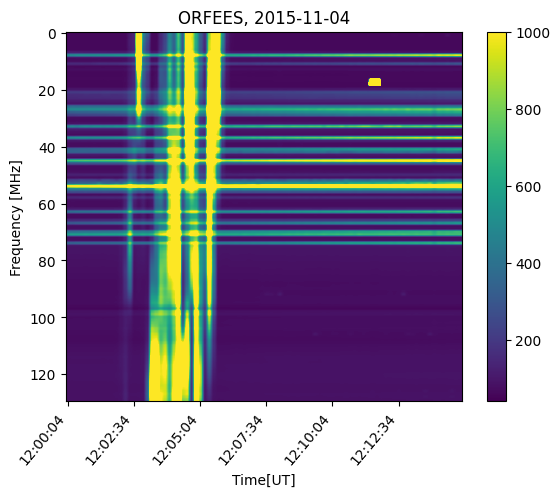

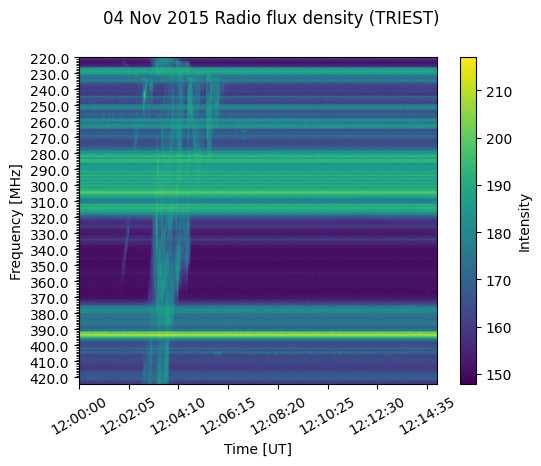

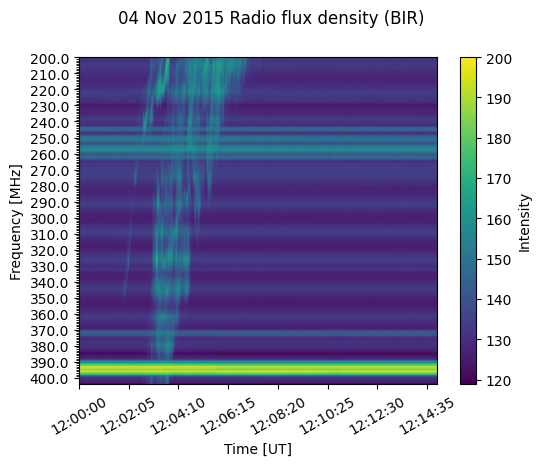

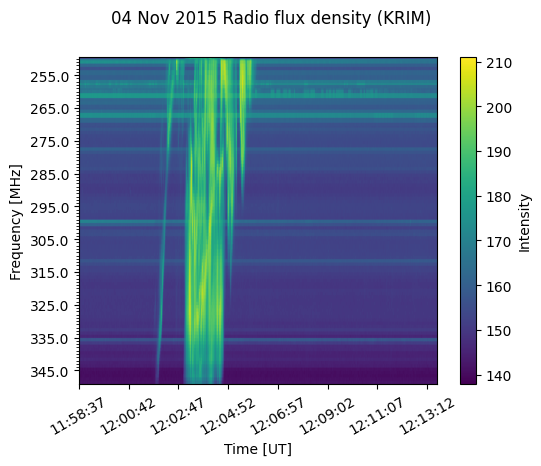

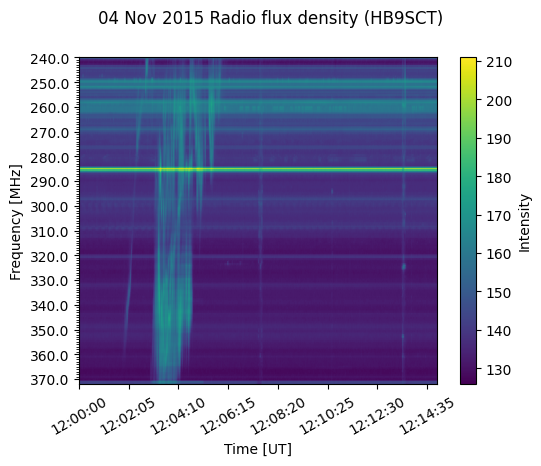

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [158]:
spec_test_1 = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
spec1 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/TRIEST_20151104_120000_59.fit.gz')
spec2 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
spec3 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/KRIM_20151104_115837_00.fit.gz')
spec4 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')

print(spec_test_1.time_start_obs)
print(spec_test_1.time_end_obs)

x = spec_test_1.time_axis
y = spec_test_1.freq_axis
# print(spec1.shape)

spec_test_1.peek()
spec1.peek()
spec2.peek()
spec3.peek()
spec4.peek()

To Do :
- Create a read metod.
- Create a select time method where we can select the timeRange we need. 